In [3]:
import re
import string
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,save_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.layers import Dense,Concatenate,LSTM,Embedding,Input,add,Dropout,BatchNormalization

In [104]:
captions_list=[]
with open('/kaggle/input/flickr8k/captions.txt','r') as file:
    for line in file:
        captions_list.append(line)

captions_list.pop(0)
captions_list[0],captions_list[100],len(captions_list)

('1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1024138940_f1fefbdce1.jpg,Two different breeds of brown and white dogs play on the beach .\n',
 40455)

In [105]:
def split_array_randomly(array, split_ratio=0.85):
    np.random.shuffle(array)
    
    split_index = int(len(array) * split_ratio)
    array1 = array[:split_index]
    array2 = array[split_index:]
    
    return list(array1), list(array2)

cap_list_train, cap_list_test = split_array_randomly(np.array(captions_list))

In [166]:
cap_dict_train = {}
for line in cap_list_train:
    try:
        img , cap =  line.split(',')
        if img not in cap_dict_train:
            cap_dict_train[img]=[]
        cap_dict_train[img].append(cap)
    except:
        continue

cap_dict_test = {}
for line in cap_list_test:
    try:
        img , cap =  line.split(',')
        if img not in cap_dict_test:
            cap_dict_test[img]=[]
        cap_dict_test[img].append(cap)
    except:
        continue

In [107]:
def clean_text(dict_):
    for img,caps in dict_.items():
        for i in range(len(caps)):
            cap = caps[i]
            text = cap.lower()
            cleaned_text = re.sub(r'\n', '', text)
            cleaned_text = re.sub(r'[^A-Za-z ]','',cleaned_text)
            cleaned_text = re.sub(r'\ba\b','',cleaned_text)
            cleaned_text = 'sos ' + cleaned_text + ' eos'
            caps[i] = cleaned_text

In [167]:
clean_text(cap_dict_train)

In [14]:
vgg_model=VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [171]:
vgg_model=Model(inputs=vgg_model.input,outputs=vgg_model.layers[-2].output)

In [22]:
img_enc={}
for im in tqdm(list(cap_dict_train.keys())):
    img=image.load_img('/kaggle/input/flickr8k/Images/'+str(im),target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    img_enc[im]=vgg_model.predict(x,verbose=0).reshape((4096,))

100%|██████████| 8090/8090 [11:15<00:00, 11.98it/s]


In [23]:
#with open('/kaggle/working/encoding_train_vgg.pkl','wb') as f:
#    pickle.dump(img_enc,f)

In [56]:
#with open('/kaggle/input/encodings/encoding_train (1).pkl','rb') as f:
#    img_enc = pickle.load(f)

In [126]:
corpus=[]
for img,caps in cap_dict_train.items():
    for cap in caps:
        corpus.append(cap)

In [129]:
tokenizer=Tokenizer(oov_token='<unk>')
tokenizer.fit_on_texts(corpus)
vocab_len=len(tokenizer.word_index)+1
vocab_len

7944

In [130]:
seq_lens=[len(cap.split(' ')) for cap in train['Caption']]
max(seq_lens),min(seq_lens)

(40, 3)

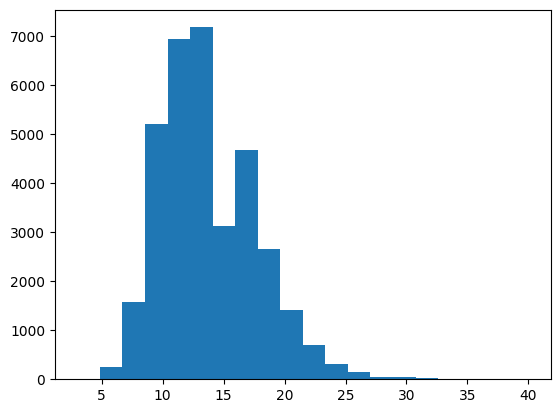

In [131]:
plt.hist(seq_lens,bins=20)
plt.show()

In [145]:
def data_generator(img_enc, mapping,tokenizer, max_length, vocab_length, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in img_enc.keys():
            try:
                captions = mapping[key]
            except:
                continue
            n += 1
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_length)[0]
                    
                    # store the sequences
                    X1.append(img_enc[key])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [153]:

# image feature layers
inputs1 = Input(shape=(4096,), name="image")
img1 = Dropout(0.4)(inputs1)
img2 = Dense(256, activation='relu')(img1)

#sequence feature layers
inputs2 = Input(shape=(26,), name="text")
seq1 = Embedding(vocab_len, 256, mask_zero=True)(inputs2)
seq2 = Dropout(0.4)(seq1)
seq3 = LSTM(256)(seq2)

# decoder model
decoder1 = add([img2, seq3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [155]:
epochs = 10
steps = len(train) // 64

for i in range(epochs):
    generator = data_generator(img_enc, cap_dict_train, tokenizer, max_length=26, vocab_length=vocab_len, batch_size=64)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [168]:
clean_text(cap_dict_test)

In [172]:
img_enc_test={}
for im in tqdm(list(cap_dict_test.keys())):
    img=image.load_img('/kaggle/input/flickr8k/Images/'+str(im),target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    img_enc_test[im]=vgg_model.predict(x,verbose=0).reshape((4096,))

100%|██████████| 4272/4272 [05:26<00:00, 13.08it/s]


In [ ]:
test = data_generator(img_enc_test, cap_dict_test, tokenizer, max_length=26, vocab_length=vocab_len, batch_size=len(cap_dict_test))
model.evaluate(test, verbose=1)

In [158]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length=26):
    in_text = 'sos'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([np.array([photo]), np.array(sequence)])
        pred = np.argmax(pred, axis=-1)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        
        in_text += ' ' + word
        
        if word == 'eos':
            break
        
    
    return in_text

In [162]:
generate_desc(model, tokenizer, photo=img_enc['2955099064_1815b00825.jpg'], max_length=26)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


'sos two men are playing basketball eos'

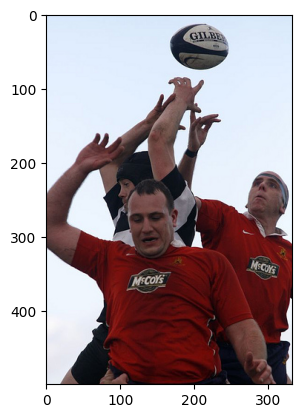

In [161]:
img=plt.imread('/kaggle/input/flickr8k/Images/2955099064_1815b00825.jpg')
plt.imshow(img)
plt.show()

In [126]:
train.head(20)

,Image,Caption
0,3164347907_2813f8ff0b.jpg,sos two people outside in the snow taking pict...
1,2602083686_e8a1af69cf.jpg,sos two ladies are wearing nothing except body...
2,2847859796_4d9cb0d31f.jpg,sos a girl with goggles on in a pool eos
3,3254645823_a7c072481c.jpg,sos two snowboarders in the air above snow eos
4,3226541300_6c81711e8e.jpg,sos two men in magenta costumes performing eos
5,2955099064_1815b00825.jpg,sos three men with football in air eos
6,537758332_8beb9cf522.jpg,sos two little girls slide down an inflated sl...
7,2716457668_187a6d2b1c.jpg,sos a child with a mohawk is wearing dark sung...
8,3599124739_b7e60cf477.jpg,sos two small girls laugh as a wave hits them ...
9,3386953179_84c2d7922f.jpg,sos a skier makes the only path on an empty mo...


In [24]:
from IPython.display import FileLink
FileLink('/kaggle/working/encoding_train_vgg.pkl')

/kaggle/working/encoding_train_vgg.pkl

In [69]:
for i,row in train.iterrows():
    print(row['Image'])
    break

2090339522_d30d2436f9.jpg
